In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="ticks", palette="pastel")

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Loading of dataset

In [3]:
path_default = "/content/drive/MyDrive/Colab Notebooks/Stock-Price-Prediction/data/stock_data.csv"
stock_data = pd.read_csv(path_default)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL
...,...,...,...,...,...,...,...,...
19581,2017-11-06,178.56000,180.45000,178.31000,180.17000,13275578,0,FB
19582,2017-11-07,180.50000,180.74800,179.40300,180.25000,12903836,0,FB
19583,2017-11-08,179.79000,180.35000,179.11000,179.56000,10467606,0,FB
19584,2017-11-09,178.31000,179.40000,177.09000,179.30000,12602188,0,FB


In [4]:
companies = stock_data['Stock'].unique()
print(companies)

['AAPL' 'TSLA' 'MSFT' 'FB']


## Split training and test set

In [5]:
stocks ={}
for i in companies:
  stocks[i] = stock_data[stock_data['Stock'] == i][["Date", "Close"]]
  print(stocks[i])

           Date      Close
0    1984-09-07    0.42388
1    1984-09-10    0.42134
2    1984-09-11    0.42902
3    1984-09-12    0.41618
4    1984-09-13    0.43927
...         ...        ...
8359 2017-11-06  173.63000
8360 2017-11-07  174.18000
8361 2017-11-08  175.61000
8362 2017-11-09  175.25000
8363 2017-11-10  174.67000

[8364 rows x 2 columns]
            Date   Close
8364  2010-06-28   17.00
8365  2010-06-29   23.89
8366  2010-06-30   23.83
8367  2010-07-01   21.96
8368  2010-07-02   19.20
...          ...     ...
10217 2017-11-06  302.78
10218 2017-11-07  306.05
10219 2017-11-08  304.31
10220 2017-11-09  302.99
10221 2017-11-10  302.99

[1858 rows x 2 columns]
            Date     Close
10222 1986-03-13   0.07533
10223 1986-03-14   0.07533
10224 1986-03-17   0.07533
10225 1986-03-18   0.07533
10226 1986-03-19   0.07533
...          ...       ...
18200 2017-11-06  84.47000
18201 2017-11-07  84.26000
18202 2017-11-08  84.56000
18203 2017-11-09  84.09000
18204 2017-11-10  83.87000

[

In [6]:
def SplitData(data, date):

  close_train = data['Close'][data['Date'] < date].to_numpy()
  data_train = []
  X_train = [] 
  Y_train = []
  for i in range(0, len(close_train), 5):
    try:
      data_train.append(close_train[i : i + 5])
    except:
      pass

  if len(data_train[-1]) < 5:
    data_train.pop(-1)
  
  X_train = data_train[0 : -1]
  X_train = np.array(X_train)
  X_train = X_train.reshape((-1, 5, 1))
  Y_train = data_train[1 : len(data_train)]
  Y_train = np.array(Y_train)
  Y_train = Y_train.reshape((-1, 5, 1))

  close_test = data['Close'][data['Date'] >= date].to_numpy()
  data_test = []
  X_test = []
  Y_test = []
  for i in range(0, len(close_test), 5):
    try:
      data_test.append(close_test[i : i + 5])
    except:
      pass

  if len(data_test[-1]) < 5:
    data_test.pop(-1)
  
  X_test = data_test[0 : -1]
  X_test = np.array(X_test)
  X_test = X_test.reshape((-1, 5, 1))
  Y_test = data_test[1 : len(data_test)]
  Y_test = np.array(Y_test)
  Y_test = Y_test.reshape((-1, 5, 1))

  return X_train, Y_train, X_test, Y_test

## Create model

In [7]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [8]:
model = Model()

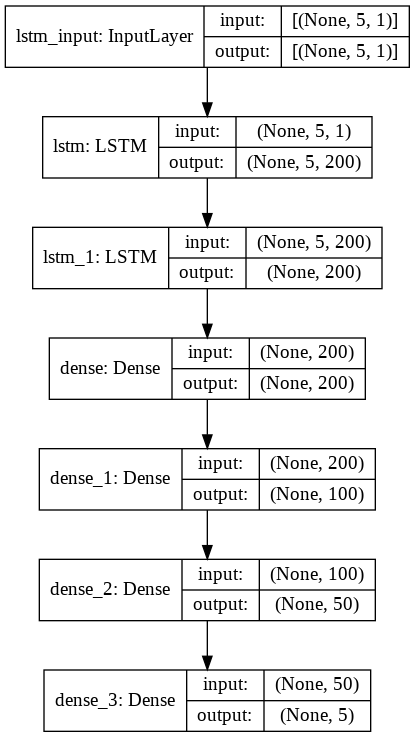

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 200)            161600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
Total params: 548,005
Trainable params: 548,005
Non-trainable params: 0
__________________________________________________

## Custom Learning Rate

In [11]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

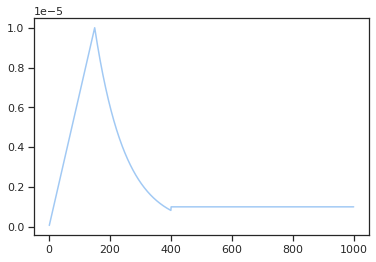

In [12]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)
plt.show()

In [13]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Train model

### Apple model

In [14]:
date_mark = '2017-01-01'
AAPL_X_train,AAPL_Y_train,AAPL_X_test,AAPL_Y_test=SplitData(stocks['AAPL'], date_mark)

In [15]:
AAPL_Model = Model()

In [16]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [17]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()
AAPL_hist = AAPL_Model.fit(AAPL_X_train, AAPL_Y_train, epochs = 1000, validation_data = (AAPL_X_test, AAPL_Y_test), callbacks=[callback])
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/1000
51/51 [==============================] - 5s 38ms/step - loss: 1391.1262 - root_mean_squared_error: 37.2978 - val_loss: 21513.9805 - val_root_mean_squared_error: 146.6765
Epoch 2/1000
51/51 [==============================] - 2s 30ms/step - loss: 1391.0581 - root_mean_squared_error: 37.2969 - val_loss: 21511.9023 - val_root_mean_squared_error: 146.6694
Epoch 3/1000
51/51 [==============================] - 2s 30ms/step - loss: 1390.8501 - root_mean_squared_error: 37.2941 - val_loss: 21507.6992 - val_root_mean_squared_error: 146.6550
Epoch 4/1000
51/51 [==============================] - 2s 30ms/step - loss: 1390.4921 - root_mean_squared_error: 37.2893 - val_loss: 21501.7207 - val_root_mean_squared_error: 146.6346
Epoch 5/1000
51/51 [==============================] - 2s 31ms/step - loss: 1389.9873 - root_mean_squared_error: 37.2825 - val_loss: 21492.9102 - val_root_mean_squared_error: 146.6046
Epoch 6/1000
51/51 [==============================] - 2s 31ms/step - loss: 1389.2988 

In [18]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

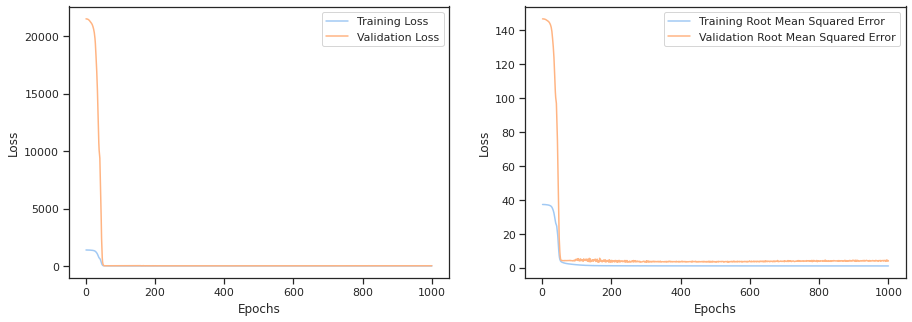

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [35]:
AAPL_prediction = AAPL_Model.predict(AAPL_X_test)

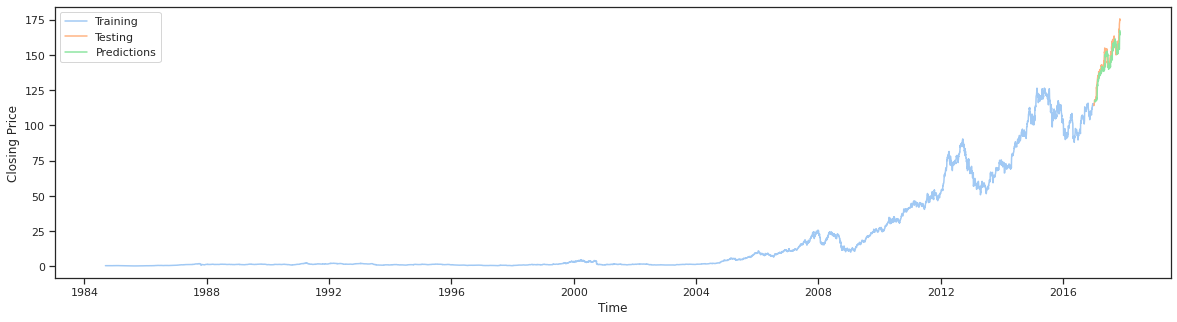

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(stocks['AAPL']['Date'][stocks['AAPL']['Date'] < date_mark], 
        stocks['AAPL']['Close'][stocks['AAPL']['Date'] < date_mark], label = 'Training')

plt.plot(stocks['AAPL']['Date'][stocks['AAPL']['Date'] >= date_mark], 
        stocks['AAPL']['Close'][stocks['AAPL']['Date'] >= date_mark], label = 'Testing')

plt.plot(stocks['AAPL']['Date'][stocks['AAPL']['Date'] >= "2017-01-13"], 
        AAPL_prediction.reshape(-1), label = 'Predictions')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [26]:
rmse = math.sqrt(mean_squared_error(AAPL_Y_test.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Y_test.reshape(-1, 5))/np.abs(AAPL_Y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 4.020172655137946
MAPE: 0.02012157740367172
